In [1]:
# 导入相关库

# PyTorch 库
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# 工具库
import numpy as np
import cv2
import random
import time
import os
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torch.autograd import Variable
import numpy as np
from math import exp
from PIL import Image

In [2]:
# SSIM损失函数实现

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [3]:
'''
Dataset for Training.
'''
class MyTrainDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        '''
        Ensure input and label are in couple.
        '''
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)

        
        return input, label

'''
Dataset for testing.
'''
class MyValidDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)
        
        return input, label

In [4]:
# 网络架构

class PReNet_r(nn.Module):
    def __init__(self, recurrent_iter=6, use_GPU=True):
        super(PReNet_r, self).__init__()
        self.iteration = recurrent_iter
        self.use_GPU = use_GPU

        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.res_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.conv_i = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_f = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_g = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Tanh()
            )
        self.conv_o = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1),
            )


    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        #mask = Variable(torch.ones(batch_size, 3, row, col)).cuda()
        x = input
        h = Variable(torch.zeros(batch_size, 32, row, col))
        c = Variable(torch.zeros(batch_size, 32, row, col))

        if self.use_GPU:
            h = h.cuda()
            c = c.cuda()

        x_list = []
        for i in range(self.iteration):
            x = torch.cat((input, x), 1)
            x = self.conv0(x)

            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * torch.tanh(c)

            x = h
            for j in range(5):
                resx = x
                x = F.relu(self.res_conv1(x) + resx)

            x = self.conv(x)
            x = input + x
            x_list.append(x)

        return x, x_list

In [5]:
'''
Check the number of GPU.
'''
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


Restart...


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 001/100 ] SSIM_loss = -0.50060
learning rate 0.001000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 001/100 ] SSIM_loss = -0.60581
[ Valid | 001/100 ] SSIM_loss = -0.60581 -> best
Best model found at epoch 1, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 002/100 ] SSIM_loss = -0.65287
learning rate 0.000999


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 002/100 ] SSIM_loss = -0.66602
[ Valid | 002/100 ] SSIM_loss = -0.66602 -> best
Best model found at epoch 2, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 003/100 ] SSIM_loss = -0.68517
learning rate 0.000998


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 003/100 ] SSIM_loss = -0.66885
[ Valid | 003/100 ] SSIM_loss = -0.66885 -> best
Best model found at epoch 3, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 004/100 ] SSIM_loss = -0.69184
learning rate 0.000996


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 004/100 ] SSIM_loss = -0.67727
[ Valid | 004/100 ] SSIM_loss = -0.67727 -> best
Best model found at epoch 4, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 005/100 ] SSIM_loss = -0.70153
learning rate 0.000994


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 005/100 ] SSIM_loss = -0.69306
[ Valid | 005/100 ] SSIM_loss = -0.69306 -> best
Best model found at epoch 5, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 006/100 ] SSIM_loss = -0.71088
learning rate 0.000991


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 006/100 ] SSIM_loss = -0.70800
[ Valid | 006/100 ] SSIM_loss = -0.70800 -> best
Best model found at epoch 6, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 007/100 ] SSIM_loss = -0.71687
learning rate 0.000988


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 007/100 ] SSIM_loss = -0.70744
[ Valid | 007/100 ] SSIM_loss = -0.70744


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 008/100 ] SSIM_loss = -0.72384
learning rate 0.000984


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 008/100 ] SSIM_loss = -0.71068
[ Valid | 008/100 ] SSIM_loss = -0.71068 -> best
Best model found at epoch 8, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 009/100 ] SSIM_loss = -0.72822
learning rate 0.000980


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 009/100 ] SSIM_loss = -0.70963
[ Valid | 009/100 ] SSIM_loss = -0.70963


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 010/100 ] SSIM_loss = -0.73568
learning rate 0.000976


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 010/100 ] SSIM_loss = -0.71941
[ Valid | 010/100 ] SSIM_loss = -0.71941 -> best
Best model found at epoch 10, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 011/100 ] SSIM_loss = -0.74205
learning rate 0.000970


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 011/100 ] SSIM_loss = -0.73036
[ Valid | 011/100 ] SSIM_loss = -0.73036 -> best
Best model found at epoch 11, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 012/100 ] SSIM_loss = -0.74410
learning rate 0.000965


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 012/100 ] SSIM_loss = -0.73446
[ Valid | 012/100 ] SSIM_loss = -0.73446 -> best
Best model found at epoch 12, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 013/100 ] SSIM_loss = -0.74898
learning rate 0.000959


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 013/100 ] SSIM_loss = -0.73660
[ Valid | 013/100 ] SSIM_loss = -0.73660 -> best
Best model found at epoch 13, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 014/100 ] SSIM_loss = -0.74886
learning rate 0.000952


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 014/100 ] SSIM_loss = -0.71643
[ Valid | 014/100 ] SSIM_loss = -0.71643


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 015/100 ] SSIM_loss = -0.74732
learning rate 0.000946


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 015/100 ] SSIM_loss = -0.74416
[ Valid | 015/100 ] SSIM_loss = -0.74416 -> best
Best model found at epoch 15, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 016/100 ] SSIM_loss = -0.75612
learning rate 0.000938


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 016/100 ] SSIM_loss = -0.73426
[ Valid | 016/100 ] SSIM_loss = -0.73426


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 017/100 ] SSIM_loss = -0.75716
learning rate 0.000930


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 017/100 ] SSIM_loss = -0.74648
[ Valid | 017/100 ] SSIM_loss = -0.74648 -> best
Best model found at epoch 17, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 018/100 ] SSIM_loss = -0.76167
learning rate 0.000922


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 018/100 ] SSIM_loss = -0.74236
[ Valid | 018/100 ] SSIM_loss = -0.74236


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 019/100 ] SSIM_loss = -0.76110
learning rate 0.000914


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 019/100 ] SSIM_loss = -0.75152
[ Valid | 019/100 ] SSIM_loss = -0.75152 -> best
Best model found at epoch 19, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 020/100 ] SSIM_loss = -0.76117
learning rate 0.000905


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 020/100 ] SSIM_loss = -0.75962
[ Valid | 020/100 ] SSIM_loss = -0.75962 -> best
Best model found at epoch 20, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 021/100 ] SSIM_loss = -0.76950
learning rate 0.000895


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 021/100 ] SSIM_loss = -0.74829
[ Valid | 021/100 ] SSIM_loss = -0.74829


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 022/100 ] SSIM_loss = -0.76728
learning rate 0.000885


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 022/100 ] SSIM_loss = -0.74204
[ Valid | 022/100 ] SSIM_loss = -0.74204


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 023/100 ] SSIM_loss = -0.76834
learning rate 0.000875


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 023/100 ] SSIM_loss = -0.75296
[ Valid | 023/100 ] SSIM_loss = -0.75296


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 024/100 ] SSIM_loss = -0.77314
learning rate 0.000864


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 024/100 ] SSIM_loss = -0.77010
[ Valid | 024/100 ] SSIM_loss = -0.77010 -> best
Best model found at epoch 24, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 025/100 ] SSIM_loss = -0.77551
learning rate 0.000854


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 025/100 ] SSIM_loss = -0.76964
[ Valid | 025/100 ] SSIM_loss = -0.76964


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 026/100 ] SSIM_loss = -0.77566
learning rate 0.000842


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 026/100 ] SSIM_loss = -0.76100
[ Valid | 026/100 ] SSIM_loss = -0.76100


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 027/100 ] SSIM_loss = -0.78035
learning rate 0.000831


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 027/100 ] SSIM_loss = -0.76053
[ Valid | 027/100 ] SSIM_loss = -0.76053


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 028/100 ] SSIM_loss = -0.77916
learning rate 0.000819


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 028/100 ] SSIM_loss = -0.76154
[ Valid | 028/100 ] SSIM_loss = -0.76154


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 029/100 ] SSIM_loss = -0.77923
learning rate 0.000806


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 029/100 ] SSIM_loss = -0.75272
[ Valid | 029/100 ] SSIM_loss = -0.75272


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 030/100 ] SSIM_loss = -0.78615
learning rate 0.000794


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 030/100 ] SSIM_loss = -0.77136
[ Valid | 030/100 ] SSIM_loss = -0.77136 -> best
Best model found at epoch 30, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 031/100 ] SSIM_loss = -0.78060
learning rate 0.000781


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 031/100 ] SSIM_loss = -0.75521
[ Valid | 031/100 ] SSIM_loss = -0.75521


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 032/100 ] SSIM_loss = -0.77908
learning rate 0.000768


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 032/100 ] SSIM_loss = -0.77633
[ Valid | 032/100 ] SSIM_loss = -0.77633 -> best
Best model found at epoch 32, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 033/100 ] SSIM_loss = -0.78765
learning rate 0.000755


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 033/100 ] SSIM_loss = -0.77217
[ Valid | 033/100 ] SSIM_loss = -0.77217


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 034/100 ] SSIM_loss = -0.78866
learning rate 0.000741


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 034/100 ] SSIM_loss = -0.76082
[ Valid | 034/100 ] SSIM_loss = -0.76082


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 035/100 ] SSIM_loss = -0.79015
learning rate 0.000727


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 035/100 ] SSIM_loss = -0.75066
[ Valid | 035/100 ] SSIM_loss = -0.75066


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 036/100 ] SSIM_loss = -0.79074
learning rate 0.000713


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 036/100 ] SSIM_loss = -0.77235
[ Valid | 036/100 ] SSIM_loss = -0.77235


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 037/100 ] SSIM_loss = -0.79024
learning rate 0.000699


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 037/100 ] SSIM_loss = -0.74891
[ Valid | 037/100 ] SSIM_loss = -0.74891


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 038/100 ] SSIM_loss = -0.79042
learning rate 0.000684


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 038/100 ] SSIM_loss = -0.77865
[ Valid | 038/100 ] SSIM_loss = -0.77865 -> best
Best model found at epoch 38, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 039/100 ] SSIM_loss = -0.79490
learning rate 0.000669


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 039/100 ] SSIM_loss = -0.77210
[ Valid | 039/100 ] SSIM_loss = -0.77210


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 040/100 ] SSIM_loss = -0.79427
learning rate 0.000655


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 040/100 ] SSIM_loss = -0.78413
[ Valid | 040/100 ] SSIM_loss = -0.78413 -> best
Best model found at epoch 40, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 041/100 ] SSIM_loss = -0.79718
learning rate 0.000639


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 041/100 ] SSIM_loss = -0.77192
[ Valid | 041/100 ] SSIM_loss = -0.77192


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 042/100 ] SSIM_loss = -0.79495
learning rate 0.000624


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 042/100 ] SSIM_loss = -0.78469
[ Valid | 042/100 ] SSIM_loss = -0.78469 -> best
Best model found at epoch 42, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 043/100 ] SSIM_loss = -0.79616
learning rate 0.000609


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 043/100 ] SSIM_loss = -0.77376
[ Valid | 043/100 ] SSIM_loss = -0.77376


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 044/100 ] SSIM_loss = -0.79853
learning rate 0.000594


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 044/100 ] SSIM_loss = -0.78715
[ Valid | 044/100 ] SSIM_loss = -0.78715 -> best
Best model found at epoch 44, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 045/100 ] SSIM_loss = -0.80105
learning rate 0.000578


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 045/100 ] SSIM_loss = -0.77085
[ Valid | 045/100 ] SSIM_loss = -0.77085


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 046/100 ] SSIM_loss = -0.79929
learning rate 0.000563


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 046/100 ] SSIM_loss = -0.77750
[ Valid | 046/100 ] SSIM_loss = -0.77750


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 047/100 ] SSIM_loss = -0.79943
learning rate 0.000547


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 047/100 ] SSIM_loss = -0.77887
[ Valid | 047/100 ] SSIM_loss = -0.77887


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 048/100 ] SSIM_loss = -0.80338
learning rate 0.000531


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 048/100 ] SSIM_loss = -0.77608
[ Valid | 048/100 ] SSIM_loss = -0.77608


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 049/100 ] SSIM_loss = -0.80499
learning rate 0.000516


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 049/100 ] SSIM_loss = -0.78158
[ Valid | 049/100 ] SSIM_loss = -0.78158


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 050/100 ] SSIM_loss = -0.80595
learning rate 0.000500


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 050/100 ] SSIM_loss = -0.78223
[ Valid | 050/100 ] SSIM_loss = -0.78223


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 051/100 ] SSIM_loss = -0.80796
learning rate 0.000484


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 051/100 ] SSIM_loss = -0.78376
[ Valid | 051/100 ] SSIM_loss = -0.78376


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 052/100 ] SSIM_loss = -0.80769
learning rate 0.000469


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 052/100 ] SSIM_loss = -0.78933
[ Valid | 052/100 ] SSIM_loss = -0.78933 -> best
Best model found at epoch 52, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 053/100 ] SSIM_loss = -0.80817
learning rate 0.000453


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 053/100 ] SSIM_loss = -0.78289
[ Valid | 053/100 ] SSIM_loss = -0.78289


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 054/100 ] SSIM_loss = -0.80974
learning rate 0.000437


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 054/100 ] SSIM_loss = -0.79013
[ Valid | 054/100 ] SSIM_loss = -0.79013 -> best
Best model found at epoch 54, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 055/100 ] SSIM_loss = -0.81090
learning rate 0.000422


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 055/100 ] SSIM_loss = -0.78604
[ Valid | 055/100 ] SSIM_loss = -0.78604


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 056/100 ] SSIM_loss = -0.80936
learning rate 0.000406


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 056/100 ] SSIM_loss = -0.79523
[ Valid | 056/100 ] SSIM_loss = -0.79523 -> best
Best model found at epoch 56, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 057/100 ] SSIM_loss = -0.80869
learning rate 0.000391


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 057/100 ] SSIM_loss = -0.78443
[ Valid | 057/100 ] SSIM_loss = -0.78443


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 058/100 ] SSIM_loss = -0.81104
learning rate 0.000376


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 058/100 ] SSIM_loss = -0.78723
[ Valid | 058/100 ] SSIM_loss = -0.78723


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 059/100 ] SSIM_loss = -0.81325
learning rate 0.000361


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 059/100 ] SSIM_loss = -0.78897
[ Valid | 059/100 ] SSIM_loss = -0.78897


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 060/100 ] SSIM_loss = -0.81313
learning rate 0.000345


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 060/100 ] SSIM_loss = -0.79303
[ Valid | 060/100 ] SSIM_loss = -0.79303


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 061/100 ] SSIM_loss = -0.81536
learning rate 0.000331


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 061/100 ] SSIM_loss = -0.79342
[ Valid | 061/100 ] SSIM_loss = -0.79342


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 062/100 ] SSIM_loss = -0.81503
learning rate 0.000316


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 062/100 ] SSIM_loss = -0.79463
[ Valid | 062/100 ] SSIM_loss = -0.79463


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 063/100 ] SSIM_loss = -0.81744
learning rate 0.000301


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 063/100 ] SSIM_loss = -0.78983
[ Valid | 063/100 ] SSIM_loss = -0.78983


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 064/100 ] SSIM_loss = -0.81640
learning rate 0.000287


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 064/100 ] SSIM_loss = -0.80077
[ Valid | 064/100 ] SSIM_loss = -0.80077 -> best
Best model found at epoch 64, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 065/100 ] SSIM_loss = -0.81798
learning rate 0.000273


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 065/100 ] SSIM_loss = -0.79408
[ Valid | 065/100 ] SSIM_loss = -0.79408


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 066/100 ] SSIM_loss = -0.81740
learning rate 0.000259


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 066/100 ] SSIM_loss = -0.79552
[ Valid | 066/100 ] SSIM_loss = -0.79552


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 067/100 ] SSIM_loss = -0.81896
learning rate 0.000245


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 067/100 ] SSIM_loss = -0.80209
[ Valid | 067/100 ] SSIM_loss = -0.80209 -> best
Best model found at epoch 67, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 068/100 ] SSIM_loss = -0.81903
learning rate 0.000232


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 068/100 ] SSIM_loss = -0.78403
[ Valid | 068/100 ] SSIM_loss = -0.78403


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 069/100 ] SSIM_loss = -0.81975
learning rate 0.000219


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 069/100 ] SSIM_loss = -0.79354
[ Valid | 069/100 ] SSIM_loss = -0.79354


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 070/100 ] SSIM_loss = -0.81937
learning rate 0.000206


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 070/100 ] SSIM_loss = -0.79426
[ Valid | 070/100 ] SSIM_loss = -0.79426


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 071/100 ] SSIM_loss = -0.81982
learning rate 0.000194


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 071/100 ] SSIM_loss = -0.79515
[ Valid | 071/100 ] SSIM_loss = -0.79515


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 072/100 ] SSIM_loss = -0.82251
learning rate 0.000181


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 072/100 ] SSIM_loss = -0.79692
[ Valid | 072/100 ] SSIM_loss = -0.79692


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 073/100 ] SSIM_loss = -0.82158
learning rate 0.000169


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 073/100 ] SSIM_loss = -0.79713
[ Valid | 073/100 ] SSIM_loss = -0.79713


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 074/100 ] SSIM_loss = -0.82375
learning rate 0.000158


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 074/100 ] SSIM_loss = -0.79754
[ Valid | 074/100 ] SSIM_loss = -0.79754


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 075/100 ] SSIM_loss = -0.82289
learning rate 0.000146


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 075/100 ] SSIM_loss = -0.79464
[ Valid | 075/100 ] SSIM_loss = -0.79464


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 076/100 ] SSIM_loss = -0.82437
learning rate 0.000136


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 076/100 ] SSIM_loss = -0.79416
[ Valid | 076/100 ] SSIM_loss = -0.79416


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 077/100 ] SSIM_loss = -0.82234
learning rate 0.000125


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 077/100 ] SSIM_loss = -0.79404
[ Valid | 077/100 ] SSIM_loss = -0.79404


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 078/100 ] SSIM_loss = -0.82457
learning rate 0.000115


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 078/100 ] SSIM_loss = -0.79319
[ Valid | 078/100 ] SSIM_loss = -0.79319


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 079/100 ] SSIM_loss = -0.82584
learning rate 0.000105


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 079/100 ] SSIM_loss = -0.79932
[ Valid | 079/100 ] SSIM_loss = -0.79932


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 080/100 ] SSIM_loss = -0.82588
learning rate 0.000095


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 080/100 ] SSIM_loss = -0.80078
[ Valid | 080/100 ] SSIM_loss = -0.80078


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 081/100 ] SSIM_loss = -0.82645
learning rate 0.000086


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 081/100 ] SSIM_loss = -0.80057
[ Valid | 081/100 ] SSIM_loss = -0.80057


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 082/100 ] SSIM_loss = -0.82542
learning rate 0.000078


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 082/100 ] SSIM_loss = -0.80241
[ Valid | 082/100 ] SSIM_loss = -0.80241 -> best
Best model found at epoch 82, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 083/100 ] SSIM_loss = -0.82674
learning rate 0.000070


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 083/100 ] SSIM_loss = -0.79598
[ Valid | 083/100 ] SSIM_loss = -0.79598


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 084/100 ] SSIM_loss = -0.82728
learning rate 0.000062


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 084/100 ] SSIM_loss = -0.79888
[ Valid | 084/100 ] SSIM_loss = -0.79888


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 085/100 ] SSIM_loss = -0.82701
learning rate 0.000054


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 085/100 ] SSIM_loss = -0.80462
[ Valid | 085/100 ] SSIM_loss = -0.80462 -> best
Best model found at epoch 85, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 086/100 ] SSIM_loss = -0.82708
learning rate 0.000048


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 086/100 ] SSIM_loss = -0.80004
[ Valid | 086/100 ] SSIM_loss = -0.80004


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 087/100 ] SSIM_loss = -0.82716
learning rate 0.000041


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 087/100 ] SSIM_loss = -0.80083
[ Valid | 087/100 ] SSIM_loss = -0.80083


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 088/100 ] SSIM_loss = -0.82875
learning rate 0.000035


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 088/100 ] SSIM_loss = -0.79987
[ Valid | 088/100 ] SSIM_loss = -0.79987


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 089/100 ] SSIM_loss = -0.82836
learning rate 0.000030


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 089/100 ] SSIM_loss = -0.79825
[ Valid | 089/100 ] SSIM_loss = -0.79825


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 090/100 ] SSIM_loss = -0.82925
learning rate 0.000024


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 090/100 ] SSIM_loss = -0.80417
[ Valid | 090/100 ] SSIM_loss = -0.80417


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 091/100 ] SSIM_loss = -0.82841
learning rate 0.000020


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 091/100 ] SSIM_loss = -0.79919
[ Valid | 091/100 ] SSIM_loss = -0.79919


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 092/100 ] SSIM_loss = -0.82868
learning rate 0.000016


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 092/100 ] SSIM_loss = -0.80563
[ Valid | 092/100 ] SSIM_loss = -0.80563 -> best
Best model found at epoch 92, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 093/100 ] SSIM_loss = -0.82987
learning rate 0.000012


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 093/100 ] SSIM_loss = -0.79115
[ Valid | 093/100 ] SSIM_loss = -0.79115


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 094/100 ] SSIM_loss = -0.82956
learning rate 0.000009


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 094/100 ] SSIM_loss = -0.80222
[ Valid | 094/100 ] SSIM_loss = -0.80222


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 095/100 ] SSIM_loss = -0.82922
learning rate 0.000006


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 095/100 ] SSIM_loss = -0.79858
[ Valid | 095/100 ] SSIM_loss = -0.79858


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 096/100 ] SSIM_loss = -0.82901
learning rate 0.000004


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 096/100 ] SSIM_loss = -0.80386
[ Valid | 096/100 ] SSIM_loss = -0.80386


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 097/100 ] SSIM_loss = -0.82964
learning rate 0.000002


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 097/100 ] SSIM_loss = -0.80199
[ Valid | 097/100 ] SSIM_loss = -0.80199


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 098/100 ] SSIM_loss = -0.82898
learning rate 0.000001


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 098/100 ] SSIM_loss = -0.79998
[ Valid | 098/100 ] SSIM_loss = -0.79998


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 099/100 ] SSIM_loss = -0.82970
learning rate 0.000000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 099/100 ] SSIM_loss = -0.80467
[ Valid | 099/100 ] SSIM_loss = -0.80467


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 100/100 ] SSIM_loss = -0.82959
learning rate 0.000000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 100/100 ] SSIM_loss = -0.79878
[ Valid | 100/100 ] SSIM_loss = -0.79878


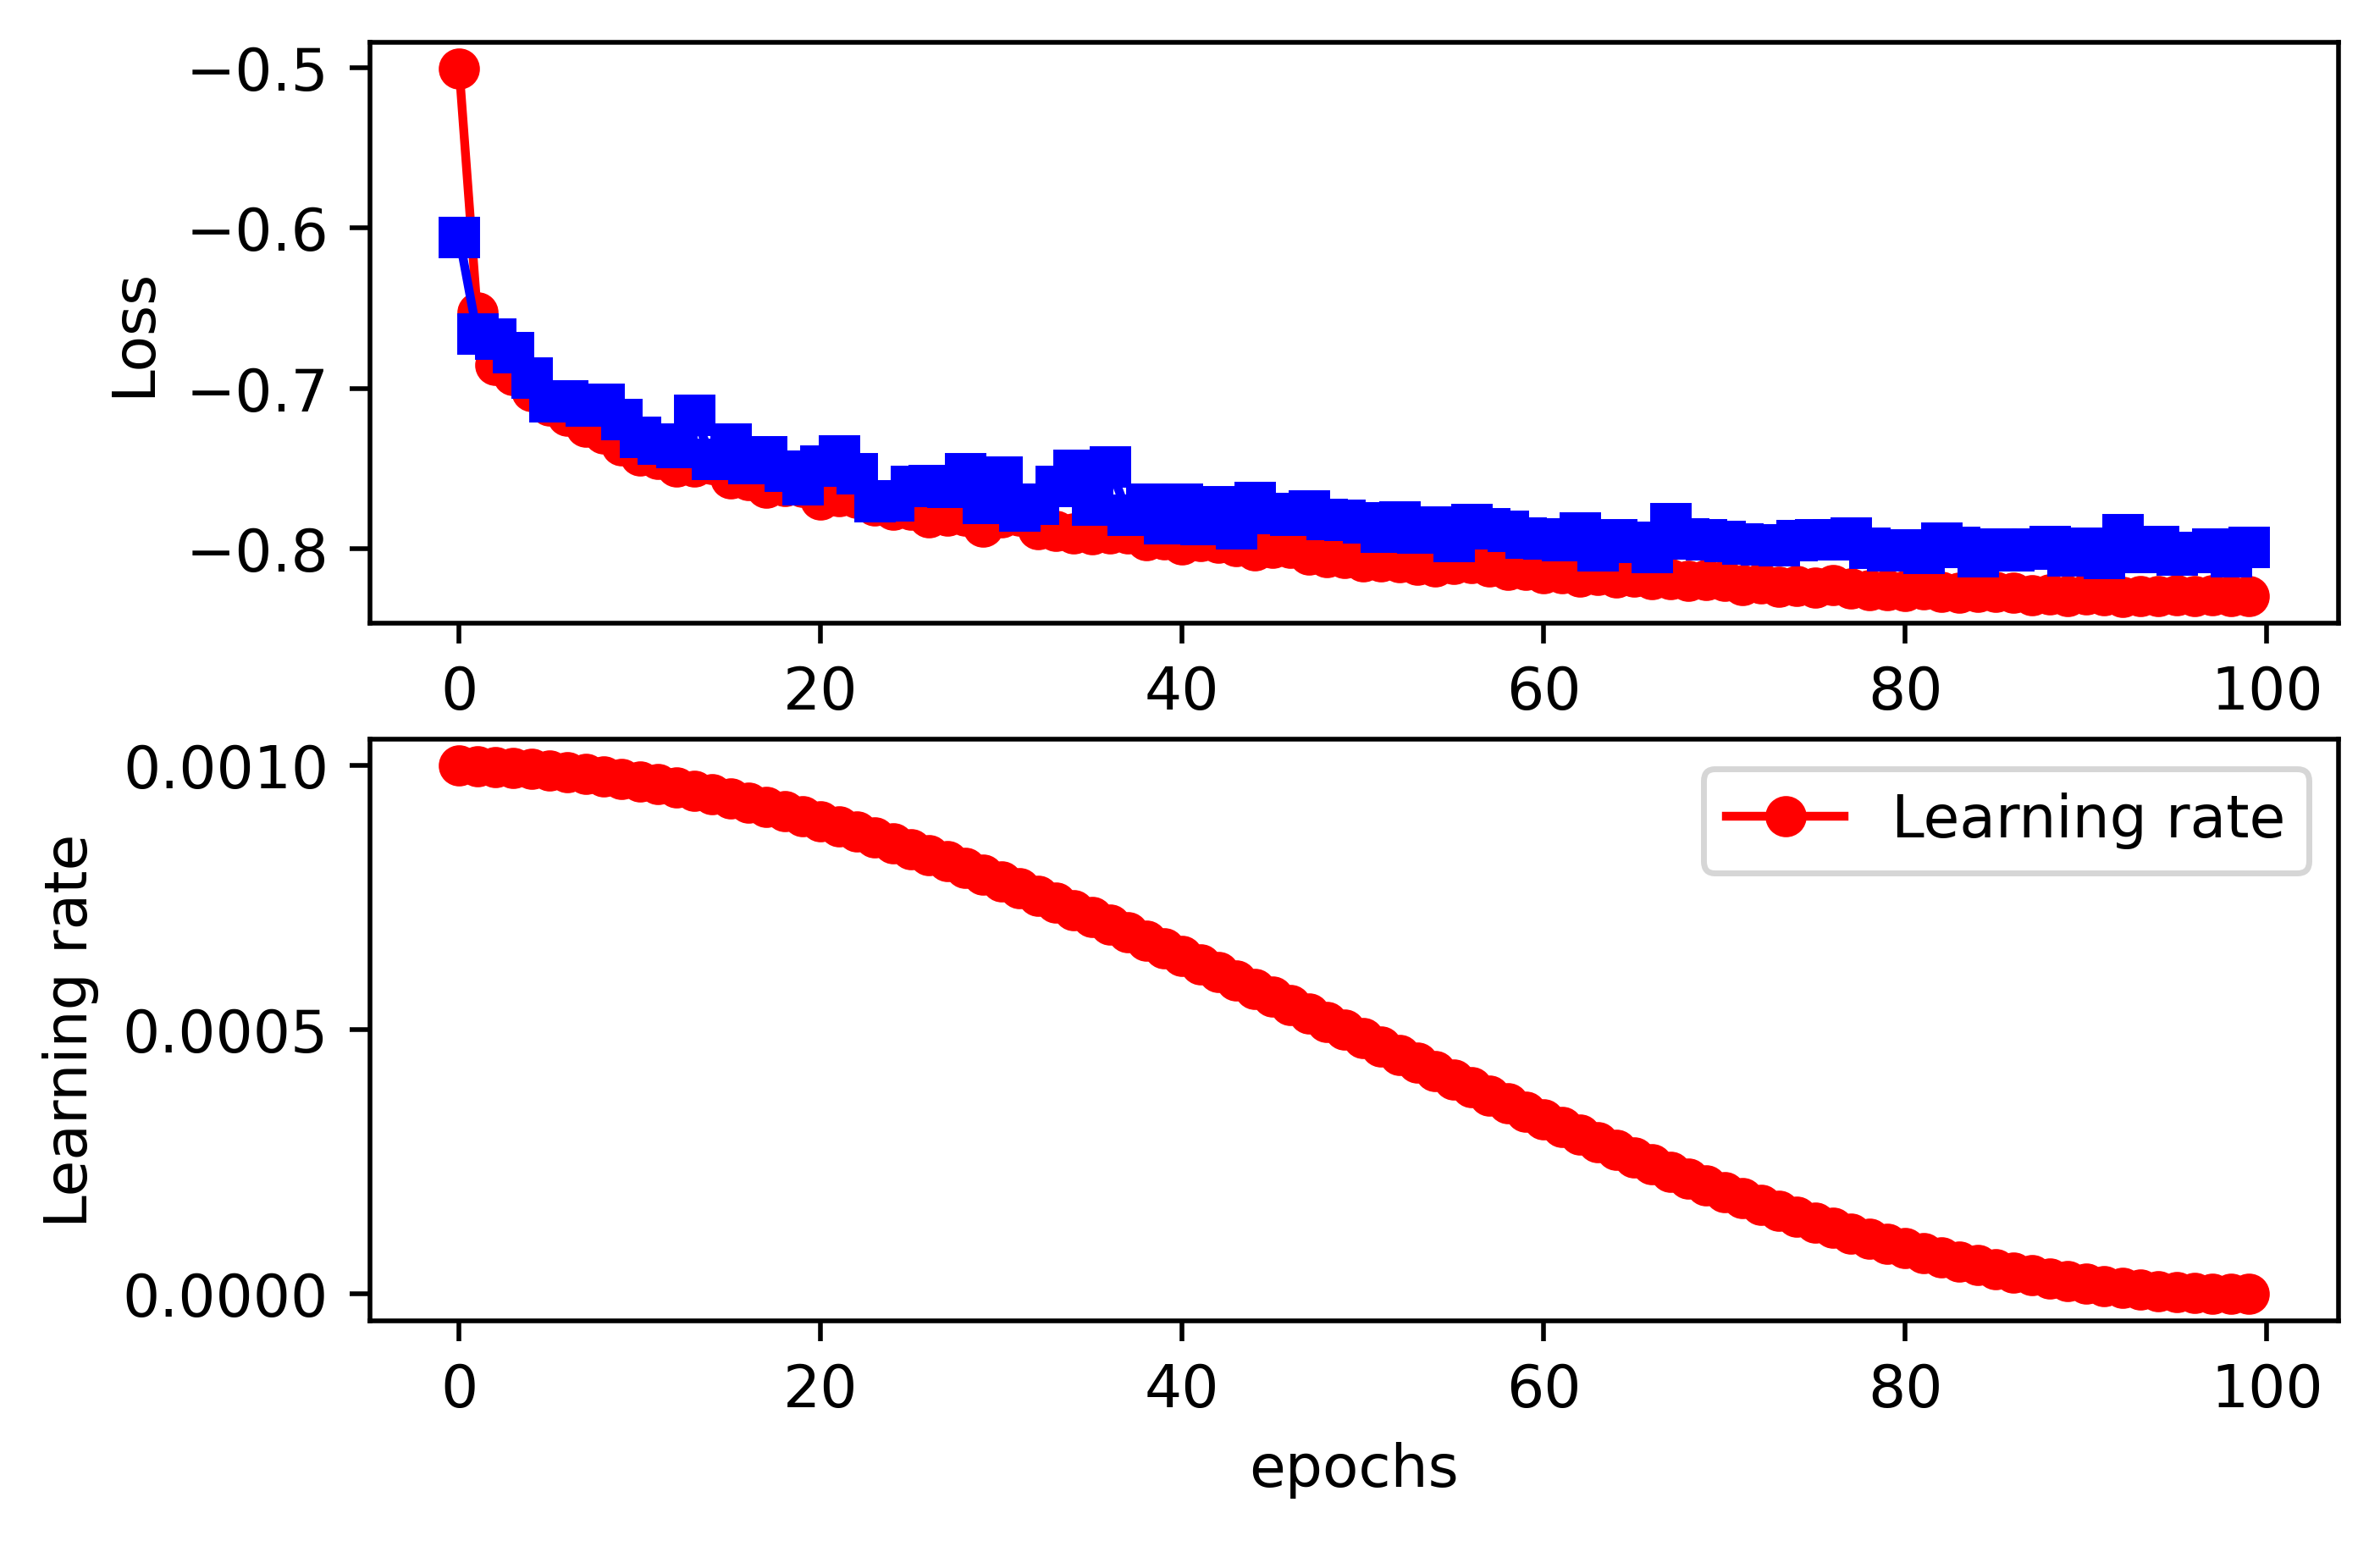

In [6]:
'''
Path of Dataset.
'''
input_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Heavy/rain/X2"
label_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Heavy/norain"
valid_input_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Heavy/rain/X2'
valid_label_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Heavy/norain'

'''
Check the device.
'''
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

'''
Move the Network to the CUDA.
'''
net = PReNet_r().to(device)

'''
Hyper Parameters.
    TODO: fine-tuning.
'''
learning_rate = 1e-3
batch_size = 32
epoch = 100
patience = 50
stale = 0
best_valid_loss = 10000
break_point = 0

'''
Prepare for plt.
'''
Loss_list = []
Valid_Loss_list = []
learning_rate_list = []

'''
Define optimizer and Loss Function.
'''
optimizer = optim.RAdam(net.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=epoch)

loss_f = SSIM()

'''
Check the model.
'''
if os.path.exists('./model.pth'): 
    print('Continue train with last model...')
    net.load_state_dict(torch.load('./model.pth'))
else: 
    print("Restart...")

'''
Prepare DataLoaders.

Attension:
    'pin_numbers=True' can accelorate CUDA computing.
'''
dataset_train = MyTrainDataset(input_path, label_path)
dataset_valid = MyValidDataset(valid_input_path, valid_label_path)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, pin_memory=True)

'''
START Training ...
'''
for i in range(epoch):
# ---------------Train----------------
    net.train()
    train_losses = []
    
    '''
    tqdm is a toolkit for progress bar.
    '''
    for batch in tqdm(train_loader):
        inputs, labels = batch
        
        outputs, _ = net(inputs.to(device))
        loss = loss_f(labels.to(device), outputs)
        loss = -loss
        
        
        optimizer.zero_grad()
        
        loss.backward()
        
        '''
        Avoid grad to be too BIG.
        '''
        grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        
        optimizer.step()
        
        '''
        Attension:
            We need set 'loss.item()' to turn Tensor into Numpy, or plt will not work.
        '''
        train_losses.append(loss.item())
        
    train_loss = sum(train_losses) / len(train_losses)
    Loss_list.append(train_loss)
    print(f"[ Train | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {train_loss:.5f}")
    
    scheduler.step()
    for param_group in optimizer.param_groups:
        learning_rate_list.append(param_group["lr"])
        print('learning rate %f' % param_group["lr"])
    
# -------------Validation-------------
    '''
    Validation is a step to ensure training process is working.
    You can also exploit Validation to see if your net work is overfitting.
    
    Firstly, you should set model.eval(), to ensure parameters not training.
    '''
    net.eval()
    valid_losses = []
    for batch in tqdm(valid_loader):
        inputs, labels = batch
        
        '''
        Cancel gradient decent.
        '''
        with torch.no_grad():
            outputs, _ = net(inputs.to(device))
        loss = loss_f(labels.to(device), outputs)
        loss = -loss
        
        
        valid_losses.append(loss.item())
    
    valid_loss = sum(valid_losses) / len(valid_losses)
    Valid_Loss_list.append(valid_loss)
    print(f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f}")
    
    break_point = i + 1
    
    '''
    Update Logs and save the best model.
    Patience is also checked.
        
    '''
    if valid_loss < best_valid_loss:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f} -> best")
    else:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f}")
    
    if valid_loss < best_valid_loss:
        print(f'Best model found at epoch {i+1}, saving model')
        torch.save(net.state_dict(), f'model_best.ckpt')
        best_valid_loss = valid_loss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f'No improvement {patience} consecutive epochs, early stopping.')
            break

'''
Use plt to draw Loss curves.
'''
plt.figure(dpi=500)

plt.subplot(211)
x = range(break_point)
y = Loss_list
plt.plot(x, y, 'ro-', label='Train Loss')
plt.plot(range(break_point), Valid_Loss_list, 'bs-', label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')

plt.subplot(212)
plt.plot(x, learning_rate_list, 'ro-', label='Learning rate')
plt.ylabel('Learning rate')
plt.xlabel('epochs')

plt.legend()
plt.show()